# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Загружаем датасет с помощью Pandas
data = pd.read_csv('AB_NYC_2019.csv')


In [200]:
# Добавляем в датасет для каждого объекта расстояние до центра Манхеттена
man_lat = (data[data['neighbourhood_group'] == 'Manhattan']['latitude'].max() - data[data['neighbourhood_group'] == 'Manhattan']['latitude'].min()) / 2
man_lon = (data[data['neighbourhood_group'] == 'Manhattan']['longitude'].max() - data[data['neighbourhood_group'] == 'Manhattan']['longitude'].min()) / 2
data['man_dist'] = abs(data['latitude'] - man_lat) + abs(data['longitude'] - man_lon)

# Кодируем числами категориальные признаки room_type и neighbourhood_group
le = LabelEncoder()
data['room_type'] = le.fit_transform(data['room_type'])
data['neighbourhood'] = le.fit_transform(data['neighbourhood'])
data['neighbourhood_group'] = le.fit_transform(data['neighbourhood_group'])

# Заполняем NoN в reviews_per_month
data['reviews_per_month'] = data['reviews_per_month'].fillna(-999)

# Отрезаем лишние колонки
cols_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review', 'latitude', 'longitude']
data = data.drop(columns=cols_to_drop)

In [165]:
data.isna().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
man_dist                          0
dtype: int64

In [190]:
data.shape

(48895, 10)

In [201]:
# Устраняем аномалии
list_neighbourhood = list(data['neighbourhood'].unique())
list_room_type = list(data['room_type'].unique())

for i in list_neighbourhood:
    for j in list_room_type:
        count = data[(data['neighbourhood'] == i) & (data['room_type'] == j)].shape[0]
        if count != 0:
            mean = int(data[(data['neighbourhood'] == i) & (data['room_type'] == j)]['price'].mean())
            std = data[(data['neighbourhood'] == i) & (data['room_type'] == j)]['price'].std()
            std = int(np.nan_to_num(std, nan=0))
            # data.loc[(data['neighbourhood'] == i) & (data['room_type'] == j) & (data['price'] > mean + 2 * std), 'price'] = mean
            mask = (data['neighbourhood'] == i) & (data['room_type'] == j) & (data['price'] > mean + 2 * std)
            data = data.drop(data[mask].index)

In [202]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1),
    data['price'],
    test_size=0.30,
    random_state=42,
)

data_pg1 = data[data['price'] < 100]

X_train_pg1, X_test_pg1,y_train_pg1, y_test_pg1 = train_test_split(
    data_pg1.drop(['price'], axis=1),
    data_pg1['price'],
    test_size=0.30,
    random_state=42,
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_test_predictions = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_test_predictions))
print("RMSE:", rmse)

X_test_pg1 = scaler.transform(X_test_pg1)
y_test_pg1_predictions = model.predict(X_test_pg1)
rmse_pg1 = np.sqrt(mean_squared_error(y_test_pg1, y_test_pg1_predictions))
print("RMSE pg1:", rmse_pg1)

RMSE: 84.9160139083158
RMSE pg1: 50.52498308506838


In [198]:
data_pg1.shape

(21844, 10)

In [59]:
# for i in list_feat2:
#     data.loc[data['neighbourhood'] == i, 'neighbourhood_1'] = data.loc[data['neighbourhood'] == i, 'neighbourhood_group']*1000 + list_feat2.index(i)
#     print(list_feat2.index(i))


In [60]:
# data[data['neighbourhood_1'] < 1000]['neighbourhood_1'].unique()

In [61]:
# Кодируем neighbourhood_1 как составной числовой признак
# list_feat2 = list(data['neighbourhood'].unique())
# for i in list_feat2:
#     data.loc[data['neighbourhood'] == i, 'neighbourhood_1'] = data.loc[data['neighbourhood'] == i, 'neighbourhood_group']*1000 + list_feat2.index(i)
#
# data['neighbourhood_1'] = data['neighbourhood_1'].astype(int)

# Отрезаем neighbourhood, вместо него будет neighbourhood_1
# cols_to_drop = ['neighbourhood',]
# data = data.drop(columns=cols_to_drop)
#
# data.head()

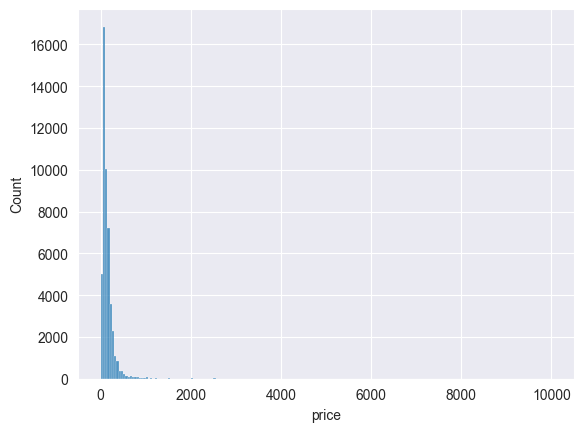

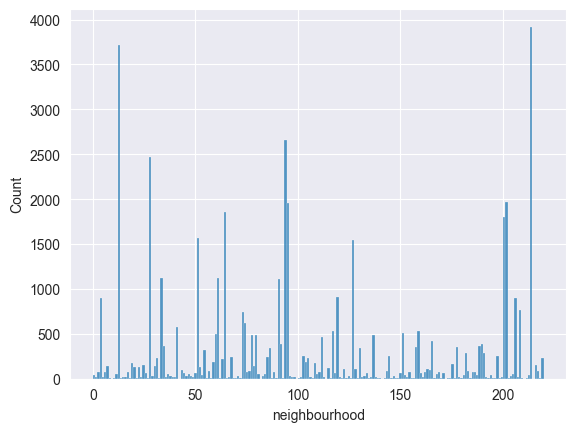

In [69]:
# for feat in ['neighbourhood_group', 'neighbourhood', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']:
for feat in ['price', 'neighbourhood']:
    sns.histplot(
            data=data,
            bins=200,
            x=feat
        )
    plt.show()

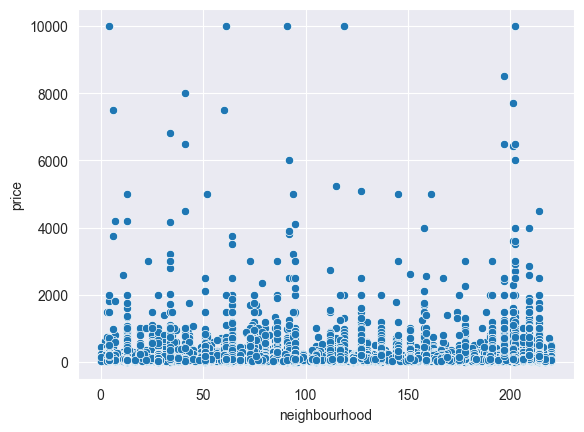

In [70]:
# sns.pairplot(
#     data[data['room_type'] == 0],
#     # vars=['neighbourhood_group', 'neighbourhood', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'],
#     vars=['neighbourhood', 'price'],
# )

sns.scatterplot(data=data, x='neighbourhood', y='price')
plt.show()

In [ ]:
# data.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

data.groupby(['neighbourhood', 'room_type'])['price'].agg(['mean', 'std']).reset_index(). head(50)


In [ ]:
data_neighbourhood = data[(data['neighbourhood'] == 3) & (data['room_type'] == 2)]
mean = data_neighbourhood['price'].mean()
std = data_neighbourhood['price'].std()

outliers = data_neighbourhood[abs(data_neighbourhood["price"] - mean) > 5 * std]
outliers.sort_values(by="price", ascending=False)

In [85]:
list_feat2 = list(data['neighbourhood'].unique())
for i in list_feat2:
    data.loc[data['neighbourhood'] == i, 'n_lat'] = (data.loc[data['neighbourhood'] == i, 'latitude'].max() - data.loc[data['neighbourhood'] == i, 'latitude'].min()) / 2
    data.loc[data['neighbourhood'] == i, 'n_lon'] = (data.loc[data['neighbourhood'] == i, 'longitude'].max() - data.loc[data['neighbourhood'] == i, 'longitude'].min()) / 2

data['dist'] = abs(data['latitude'] - data['n_lat']) + abs(data['longitude'] - data['n_lon'])

cols_to_drop = ['n_lat', 'n_lon', 'latitude', 'longitude']
data = data.drop(columns=cols_to_drop)


In [88]:
cols_to_drop = ['n_lat', 'n_lon', 'latitude', 'longitude']
data = data.drop(columns=cols_to_drop)

data.sort_values(by="neighbourhood").head()


,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist
30055,0,0,250,2,22,1.44,5,361,114.735535
1578,0,1,39,2,169,2.07,4,306,114.734645
23278,0,1,49,3,1,0.04,1,0,114.727635
17629,0,1,50,1,8,0.23,1,280,114.719215
1706,0,1,38,1,187,2.34,4,241,114.733345


In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1),
    data['price'],
    test_size=0.30,
    random_state=42,
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_test_predictions = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_test_predictions))
print("RMSE:", rmse)



RMSE: 188.56833975242077


In [171]:
# data[(data['neighbourhood_group'] == 0) & (data['price'] > 2000)].head()



data_neighbourhood = data[(data['neighbourhood_group'] == 3) & (data['room_type'] == 2)]
mean = data_neighbourhood['price'].mean()
std = data_neighbourhood['price'].std()

outliers = data_neighbourhood[abs(data_neighbourhood["price"] - mean) > 5 * std]
outliers.sort_values(by="price", ascending=False)
# data_neighbourhood

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist
14380,3,3004,40.76626,-73.93054,2,1800,3,5,0.13,2,90,148.05944
30080,3,3117,40.74786,-73.94628,2,1250,1,1,0.06,1,173,148.09358
23545,3,3077,40.76796,-73.81732,2,1000,1,0,-999.00,1,0,147.94452
